In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA,TruncatedSVD
import matplotlib.patches as mpatches
import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from collections import Counter
from sklearn.model_selection import StratifiedKFold, KFold
import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [16]:
df = df.dropna()

df.isnull().sum().max()

0

In [17]:
print("Frauds", round(df['Class'].value_counts()[0]/len(df)*100,2), '%')
print("No Frauds", round(df['Class'].value_counts()[1]/len(df)*100,2), '%')

Frauds 99.82 %
No Frauds 0.18 %


<Axes: xlabel='Class', ylabel='count'>

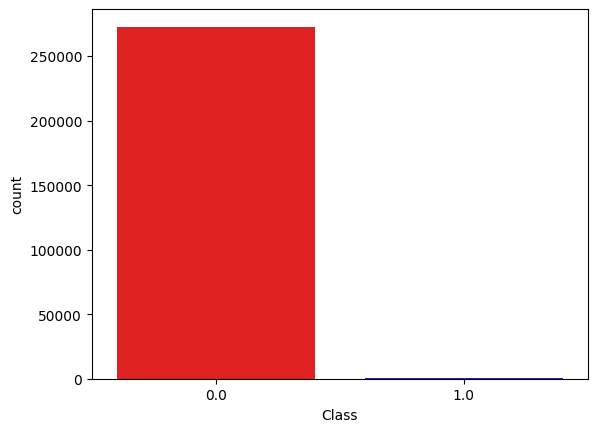

In [18]:
colors = ["red", "blue"]
sns.countplot(data=df,x="Class", palette=colors)

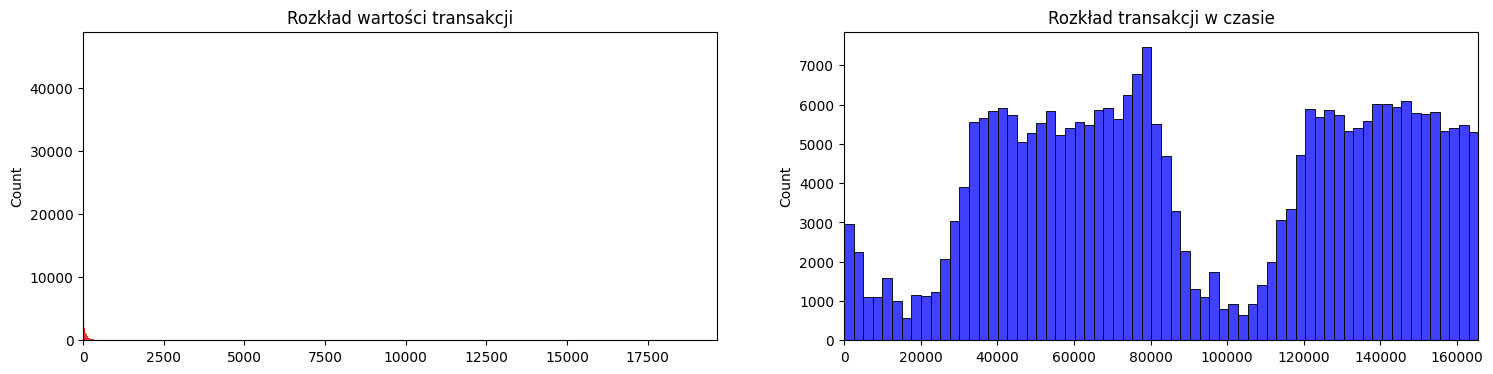

In [19]:

fig, ax = plt.subplots(1, 2, figsize=(18, 4))

amount_val = df["Amount"].values
time_val = df["Time"].values

sns.histplot(amount_val, ax=ax[0], color="r")
ax[0].set_title("Rozkład wartości transakcji")
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.histplot(time_val, ax=ax[1], color="b")
ax[1].set_title("Rozkład transakcji w czasie")
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [20]:
#scaling values
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df["scaled_amount"] = rob_scaler.fit_transform(df["Amount"].values.reshape(-1,1))
df["scaled_time"] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1,inplace=True)

In [21]:
scaled_amount = df["scaled_amount"]
scaled_time = df["scaled_time"]

df.drop(['scaled_amount','scaled_time'], axis=1,inplace=True)
df.insert(0,'scaled_amount',scaled_amount)
df.insert(0,'scaled_time',scaled_time)

df.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.990471,1.751447,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.0
1,-0.990471,-0.272940,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.0
2,-0.990458,4.907137,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.0
3,-0.990458,1.391568,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.0
4,-0.990446,0.654312,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.0


In [22]:
X, y = df.drop('Class', axis=1), df["Class"]

starfield = StratifiedKFold(n_splits=5,random_state=None,shuffle=False)


for train_index, test_index in starfield.split(X, y):
    print('Train: ', train_index, "Test: ", test_index)

    original_Xtrain, originalXtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, originalytest = y.iloc[train_index], y.iloc[test_index]

original_Xtrain = original_Xtrain.values
originalXtest = originalXtest.values
original_ytrain = original_ytrain.values
originalytest = originalytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(originalytest, return_counts=True)

print("Rozkład klas w zbiorze treningowym:")
print(train_counts_label / len(original_ytrain))

print("Rozkład klas w zbiorze testowym:")
print(test_counts_label / len(originalytest))

Train:  [ 30398  30442  30473 ... 273258 273259 273260] Test:  [    0     1     2 ... 54708 54709 54710]
Train:  [     0      1      2 ... 273258 273259 273260] Test:  [ 30398  30442  30473 ... 109348 109349 109350]
Train:  [     0      1      2 ... 273258 273259 273260] Test:  [ 79835  79874  79883 ... 164023 164024 164025]
Train:  [     0      1      2 ... 273258 273259 273260] Test:  [149587 149600 149869 ... 218625 218626 218627]
Train:  [     0      1      2 ... 218625 218626 218627] Test:  [201098 201601 203324 ... 273258 273259 273260]
Rozkład klas w zbiorze treningowym:
[0.99823886 0.00176114]
Rozkład klas w zbiorze testowym:
[0.99822513 0.00177487]


In [23]:
X, y = df.drop('Class', axis=1), df["Class"]

starfield = StratifiedKFold(n_splits=5,random_state=None,shuffle=False)


for train_index, test_index in starfield.split(X, y):
    print('Train: ', train_index, "Test: ", test_index)

    original_Xtrain, originalXtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, originalytest = y.iloc[train_index], y.iloc[test_index]

original_Xtrain = original_Xtrain.values
originalXtest = originalXtest.values
original_ytrain = original_ytrain.values
originalytest = originalytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(originalytest, return_counts=True)

print("Rozkład klas w zbiorze treningowym:")
print(train_counts_label / len(original_ytrain))

print("Rozkład klas w zbiorze testowym:")
print(test_counts_label / len(originalytest))

Train:  [ 30398  30442  30473 ... 273258 273259 273260] Test:  [    0     1     2 ... 54708 54709 54710]
Train:  [     0      1      2 ... 273258 273259 273260] Test:  [ 30398  30442  30473 ... 109348 109349 109350]
Train:  [     0      1      2 ... 273258 273259 273260] Test:  [ 79835  79874  79883 ... 164023 164024 164025]
Train:  [     0      1      2 ... 273258 273259 273260] Test:  [149587 149600 149869 ... 218625 218626 218627]
Train:  [     0      1      2 ... 218625 218626 218627] Test:  [201098 201601 203324 ... 273258 273259 273260]
Rozkład klas w zbiorze treningowym:
[0.99823886 0.00176114]
Rozkład klas w zbiorze testowym:
[0.99822513 0.00177487]


Under sampling

In [24]:
df.sample(frac=1)

fraud_df = df.loc[df["Class"] == 1]
non_fraud_df = df.loc[df["Class"] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
82400,-0.271402,-0.048498,-7.626924,-6.976420,-2.077911,3.416754,4.458758,-5.080408,-6.578948,1.760341,...,2.875260,1.224795,-0.656639,-0.330811,-0.078946,0.270306,0.431119,0.821381,-1.056088,1.0
57,-0.989998,-0.119317,-1.330882,0.267540,-0.168470,-0.701232,3.281972,3.216390,-0.059394,0.895430,...,-0.113875,-0.151042,-0.311726,-0.374793,1.014886,0.353992,-0.510327,0.159033,0.228708,0.0
69980,-0.340748,-0.310003,-1.739341,1.344521,-0.534379,3.195291,-0.416196,-1.261961,-2.340991,0.713004,...,0.002749,0.383180,-0.213952,-0.336640,0.237076,0.246003,-0.044228,0.510729,0.220952,1.0
252774,0.898046,-0.299394,-1.201398,4.864535,-8.328823,7.652399,-0.167445,-2.767695,-3.176421,1.623279,...,0.597026,0.532320,-0.556913,0.192444,-0.698588,0.025003,0.514968,0.378105,-0.053133,1.0
15506,-0.664762,1.067649,-21.885434,12.930505,-24.098872,6.203314,-16.466099,-4.459842,-16.519836,14.535565,...,1.611998,1.762232,-1.579055,-0.951043,0.134565,1.507110,-0.222671,1.527655,0.453699,1.0


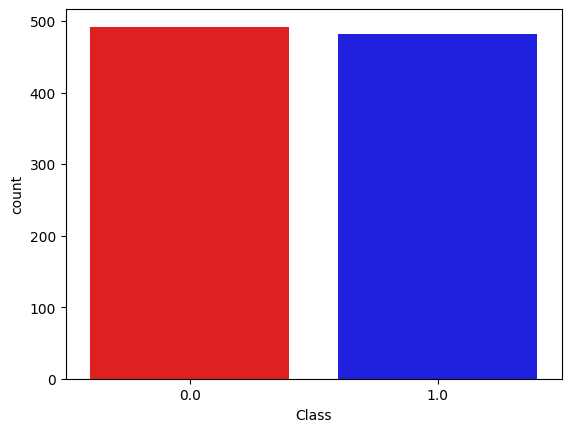

In [25]:
sns.countplot(x="Class", data=new_df, palette=colors)
plt.show()

Text(0.5, 1.0, 'Macierz korelacji dla zbalansowanego zbioru')

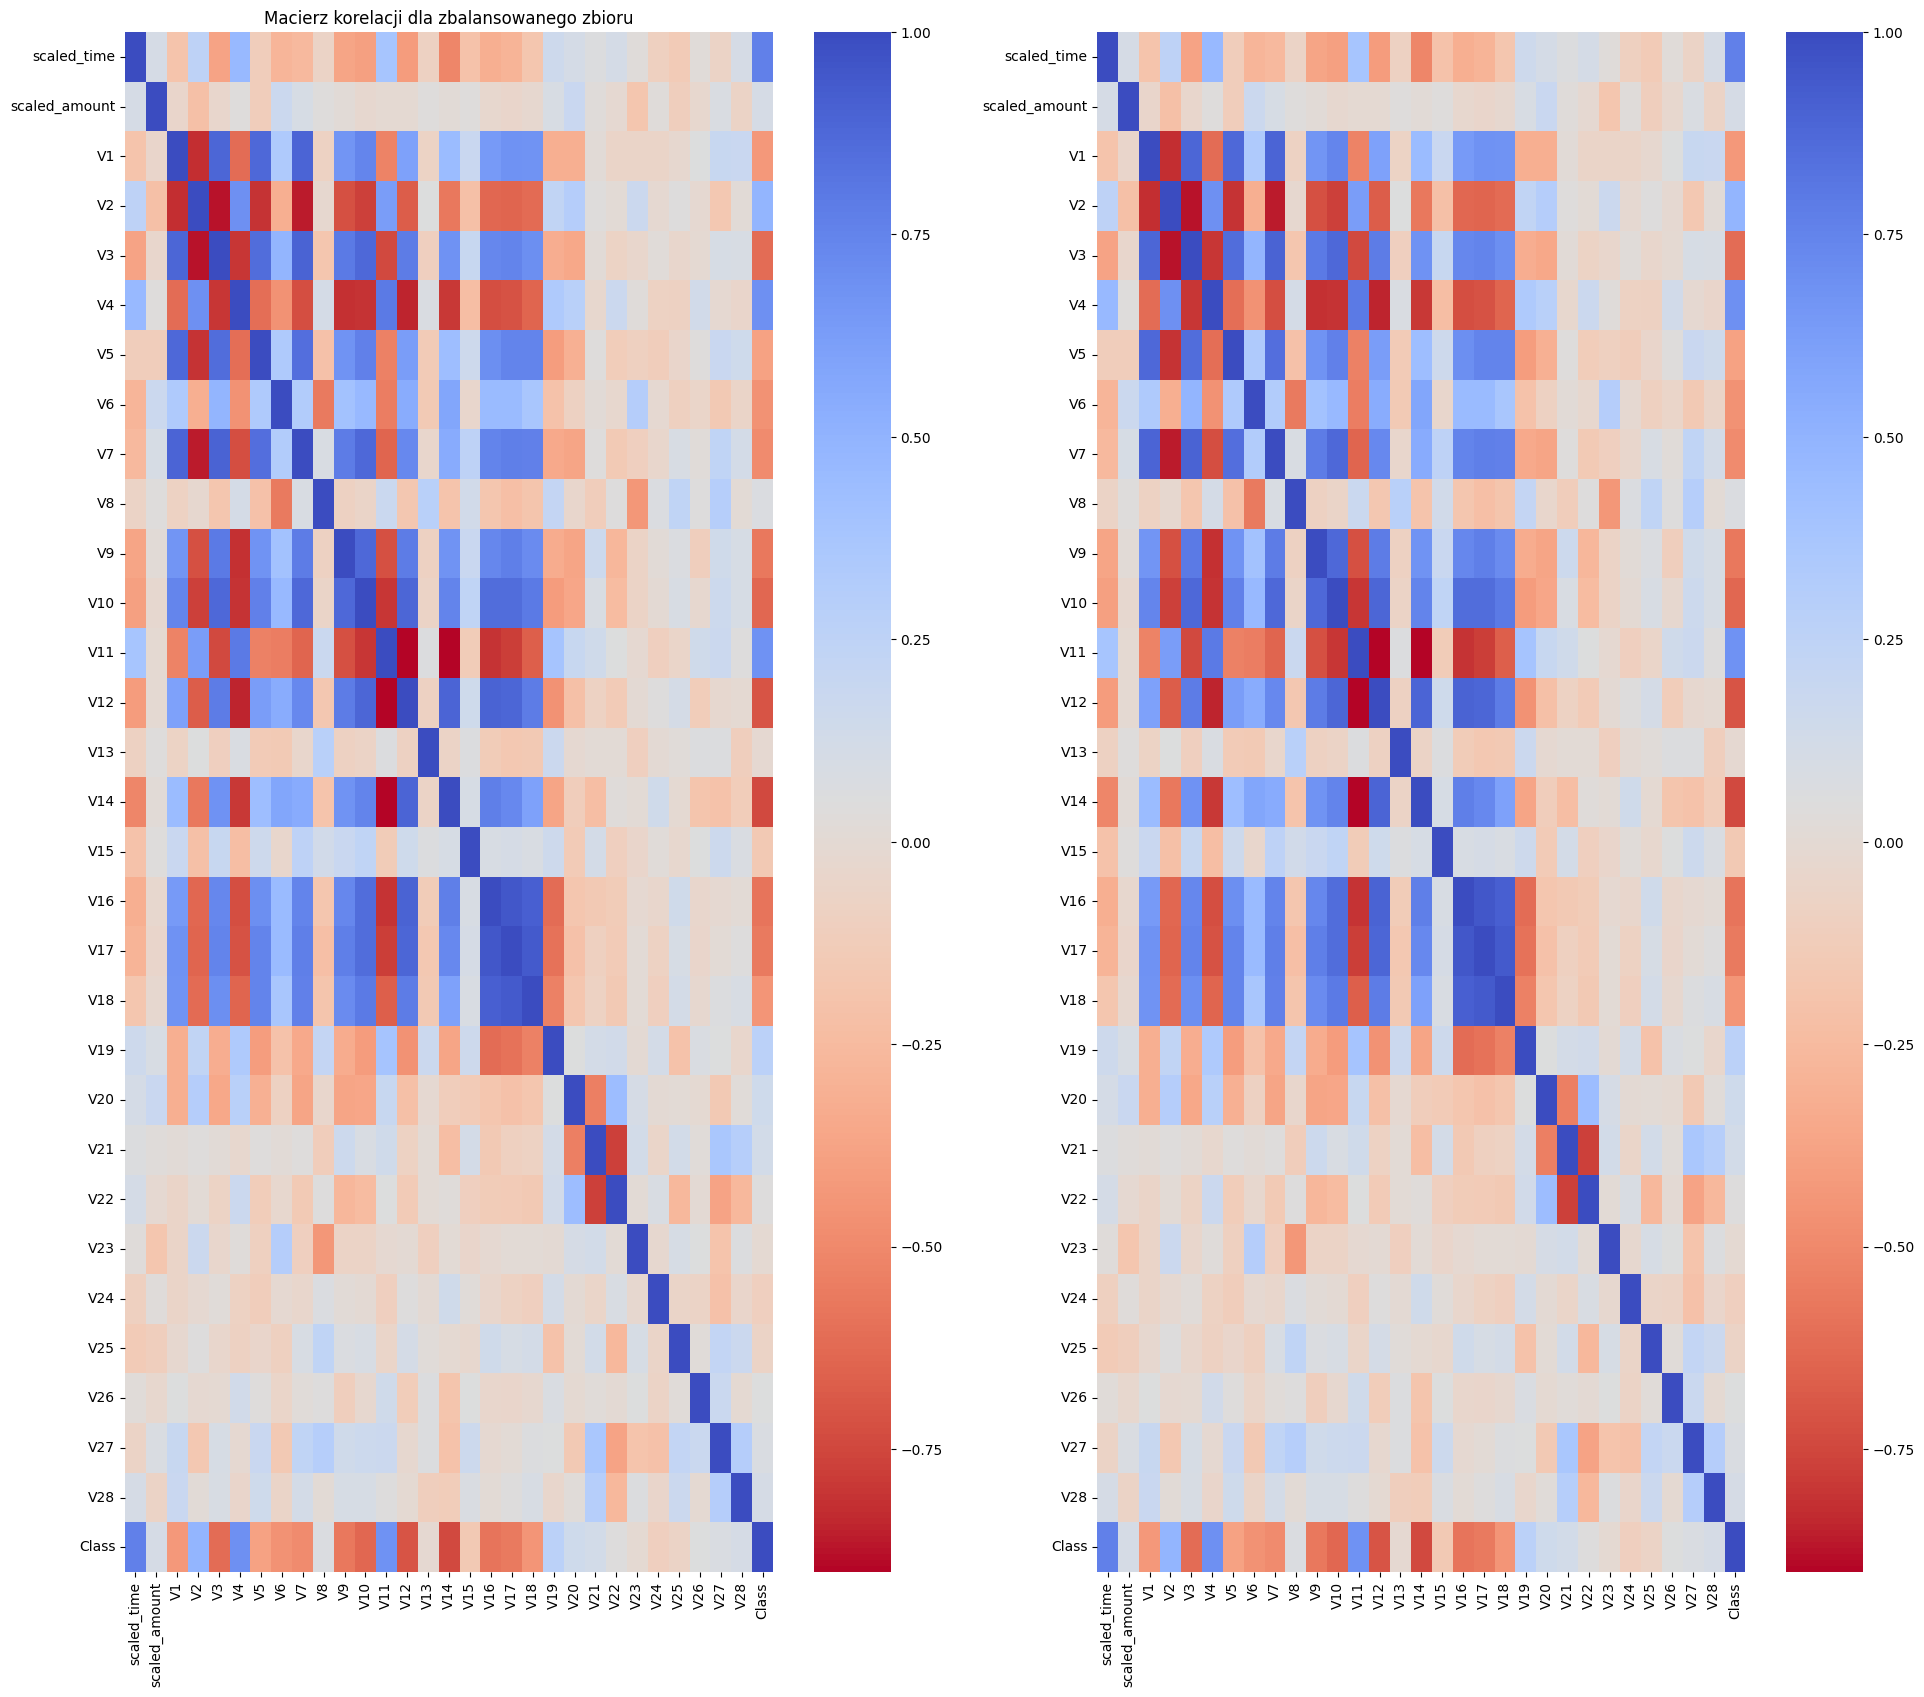

In [26]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(23,20))

corr = new_df.corr()
sns.heatmap(corr, cmap="coolwarm_r", annot_kws={'size':20}, ax=ax1)
ax1.set_title('Macierz korelacji dla niezbalansowanego zbioru')

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap="coolwarm_r", annot_kws={'size':20}, ax=ax2)
ax1.set_title('Macierz korelacji dla zbalansowanego zbioru')

Text(0.5, 1.0, 'Korelacja pomiedzy v10 a klasa')

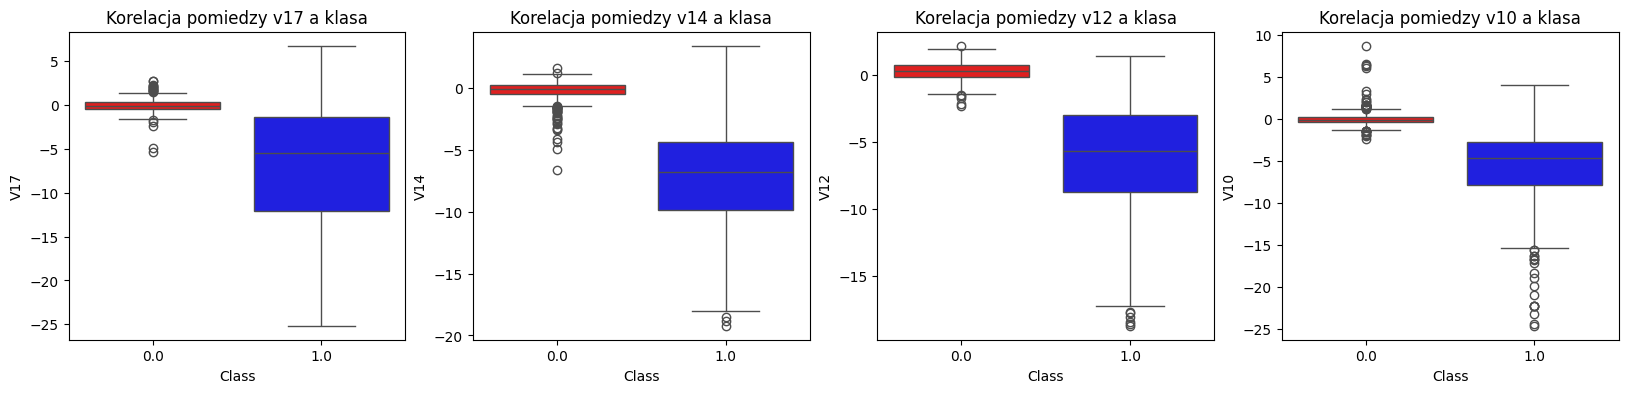

In [27]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x='Class',y='V17',data=new_df,palette=colors,ax=axes[0])
axes[0].set_title('Korelacja pomiedzy v17 a klasa')

sns.boxplot(x='Class',y='V14',data=new_df,palette=colors,ax=axes[1])
axes[1].set_title('Korelacja pomiedzy v14 a klasa')

sns.boxplot(x='Class',y='V12',data=new_df,palette=colors,ax=axes[2])
axes[2].set_title('Korelacja pomiedzy v12 a klasa')

sns.boxplot(x='Class',y='V10',data=new_df,palette=colors,ax=axes[3])
axes[3].set_title('Korelacja pomiedzy v10 a klasa')

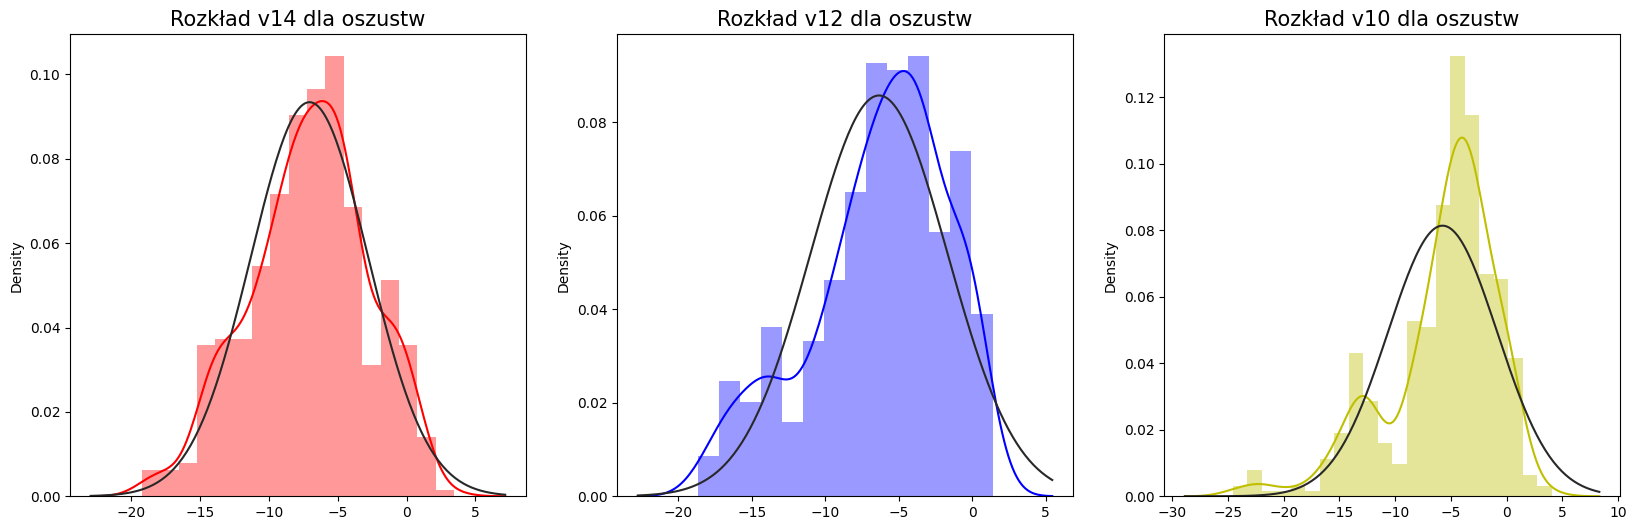

In [28]:
from scipy.stats import norm

f, (ax1,ax2,ax3, ) = plt.subplots(1,3,figsize=(20,6))

v14_fraud_dist = new_df['V14'].loc[new_df["Class"] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1,fit=norm, color='r')
ax1.set_title('Rozkład v14 dla oszustw', fontsize=15)

v12_fraud_dist = new_df['V12'].loc[new_df["Class"] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2,fit=norm, color='b')
ax2.set_title('Rozkład v12 dla oszustw', fontsize=15)

v10_fraud_dist = new_df['V10'].loc[new_df["Class"] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3,fit=norm, color='y')
ax3.set_title('Rozkład v10 dla oszustw', fontsize=15)

plt.show()

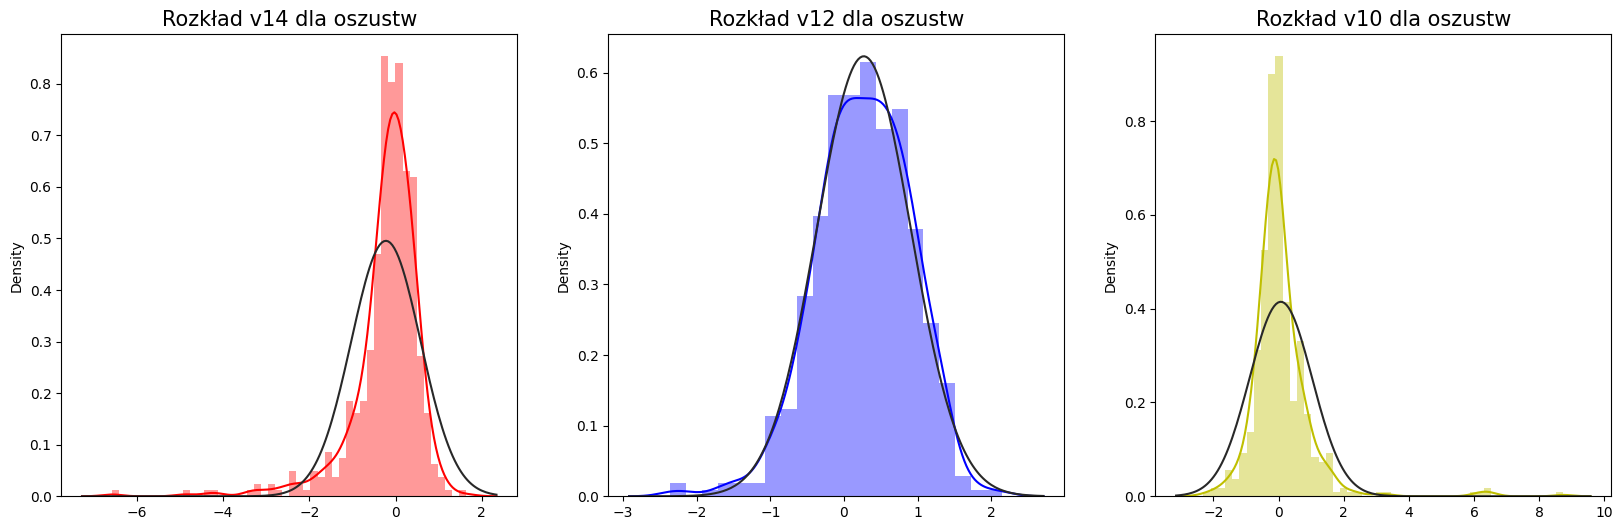

In [29]:
f, (ax1,ax2,ax3, ) = plt.subplots(1,3,figsize=(20,6))

v14_fraud_dist = new_df['V14'].loc[new_df["Class"] == 0].values
sns.distplot(v14_fraud_dist, ax=ax1,fit=norm, color='r')
ax1.set_title('Rozkład v14 dla oszustw', fontsize=15)

v12_fraud_dist = new_df['V12'].loc[new_df["Class"] == 0].values
sns.distplot(v12_fraud_dist, ax=ax2,fit=norm, color='b')
ax2.set_title('Rozkład v12 dla oszustw', fontsize=15)

v10_fraud_dist = new_df['V10'].loc[new_df["Class"] == 0].values
sns.distplot(v10_fraud_dist, ax=ax3,fit=norm, color='y')
ax3.set_title('Rozkład v10 dla oszustw', fontsize=15)

plt.show()

In [30]:
#deleting outliers
v14_fraud = new_df["V14"].loc[new_df["Class"]==1].values
q25,q75 = np.percentile(v14_fraud,25), np.percentile(v14_fraud,75)
v14_iqr = q75-q25
print(q25,q75)
print(v14_iqr)
v14_dut_off =  v14_iqr*1.5
v14_lower,v14_upper = q25-v14_dut_off, q75+v14_dut_off
print(v14_dut_off,v14_lower,v14_upper)

outliers = [x for x in v14_fraud if x<v14_lower or x>v14_upper]
print(outliers)

new_df = new_df.drop(
    new_df[
        (new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)
    ].index
)

-9.821261191288045 -4.333933542522742
5.487327648765302
8.230991473147954 -18.052252664435997 3.8970579306252118
[np.float64(-18.4937733551053), np.float64(-19.2143254902614), np.float64(-18.8220867423816)]


In [31]:
v12_fraud = new_df["V12"].loc[new_df["Class"] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
print(q25, q75)
print(v12_iqr)
v12_dut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_dut_off, q75 + v12_dut_off
print(v12_dut_off, v12_lower, v12_upper)

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print(outliers)

new_df = new_df.drop(
    new_df[
        (new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)
    ].index
)

-8.694744111941091 -3.01626596018599
5.678478151755101
8.517717227632652 -17.212461339573743 5.501451267446662
[np.float64(-18.6837146333443), np.float64(-18.4311310279993), np.float64(-18.0475965708216), np.float64(-18.5536970096458)]


In [32]:
v10_fraud = new_df["V10"].loc[new_df["Class"] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
print(q25, q75)
print(v10_iqr)
v10_dut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_dut_off, q75 + v10_dut_off
print(v10_dut_off, v10_lower, v10_upper)

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print(outliers)

new_df = new_df.drop(
    new_df[
        (new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)
    ].index
)

-7.5500013583749706 -2.64342378742311
4.90657757095186
7.359866356427791 -14.909867714802761 4.7164425690046805
[np.float64(-14.9246547735487), np.float64(-16.6011969664137), np.float64(-19.836148851696), np.float64(-16.3035376590131), np.float64(-15.3460988468775), np.float64(-22.1870885620007), np.float64(-15.5637913387301), np.float64(-18.2711681738888), np.float64(-22.1870885620007), np.float64(-20.9491915543611), np.float64(-24.5882624372475), np.float64(-22.1870885620007), np.float64(-15.2399619587112), np.float64(-15.2318333653018), np.float64(-23.2282548357516), np.float64(-16.2556117491401), np.float64(-14.9246547735487), np.float64(-17.1415136412892), np.float64(-15.2399619587112), np.float64(-15.1241628144947), np.float64(-22.1870885620007), np.float64(-16.6496281595399), np.float64(-24.4031849699728), np.float64(-15.1237521803455), np.float64(-16.7460441053944), np.float64(-15.5637913387301), np.float64(-18.9132433348732)]


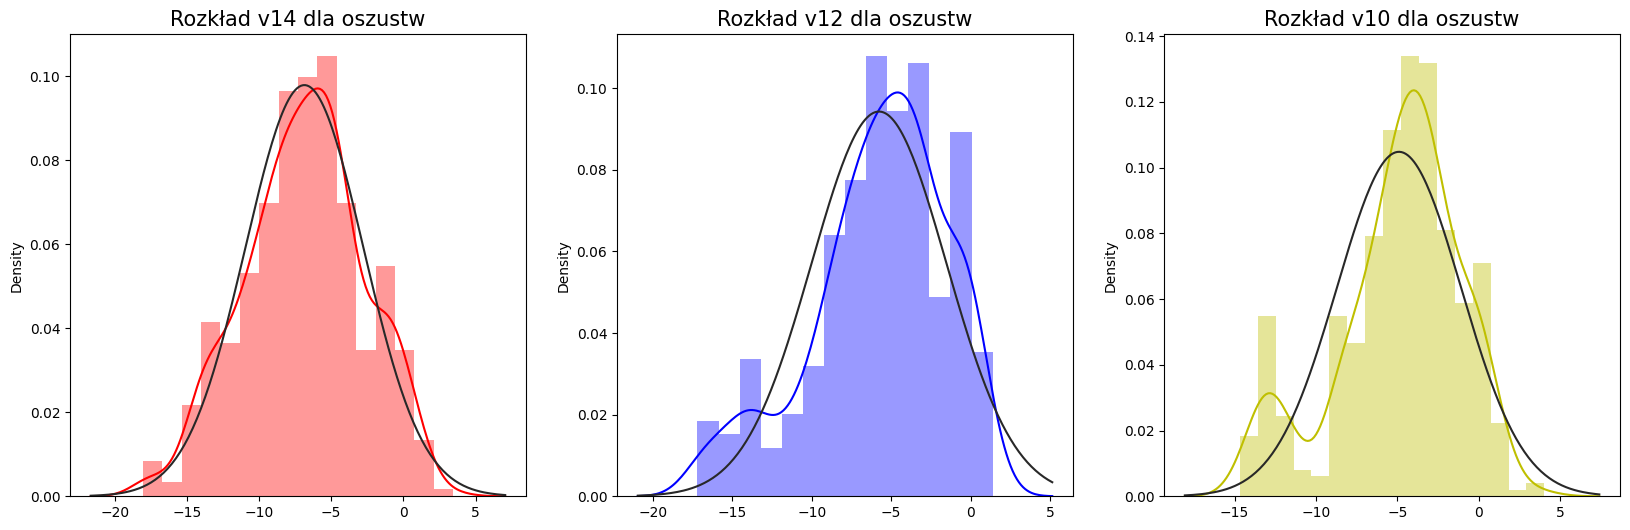

In [33]:
f, (ax1,ax2,ax3, ) = plt.subplots(1,3,figsize=(20,6))

v14_fraud_dist = new_df['V14'].loc[new_df["Class"] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1,fit=norm, color='r')
ax1.set_title('Rozkład v14 dla oszustw', fontsize=15)

v12_fraud_dist = new_df['V12'].loc[new_df["Class"] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2,fit=norm, color='b')
ax2.set_title('Rozkład v12 dla oszustw', fontsize=15)

v10_fraud_dist = new_df['V10'].loc[new_df["Class"] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3,fit=norm, color='y')
ax3.set_title('Rozkład v10 dla oszustw', fontsize=15)

plt.show()

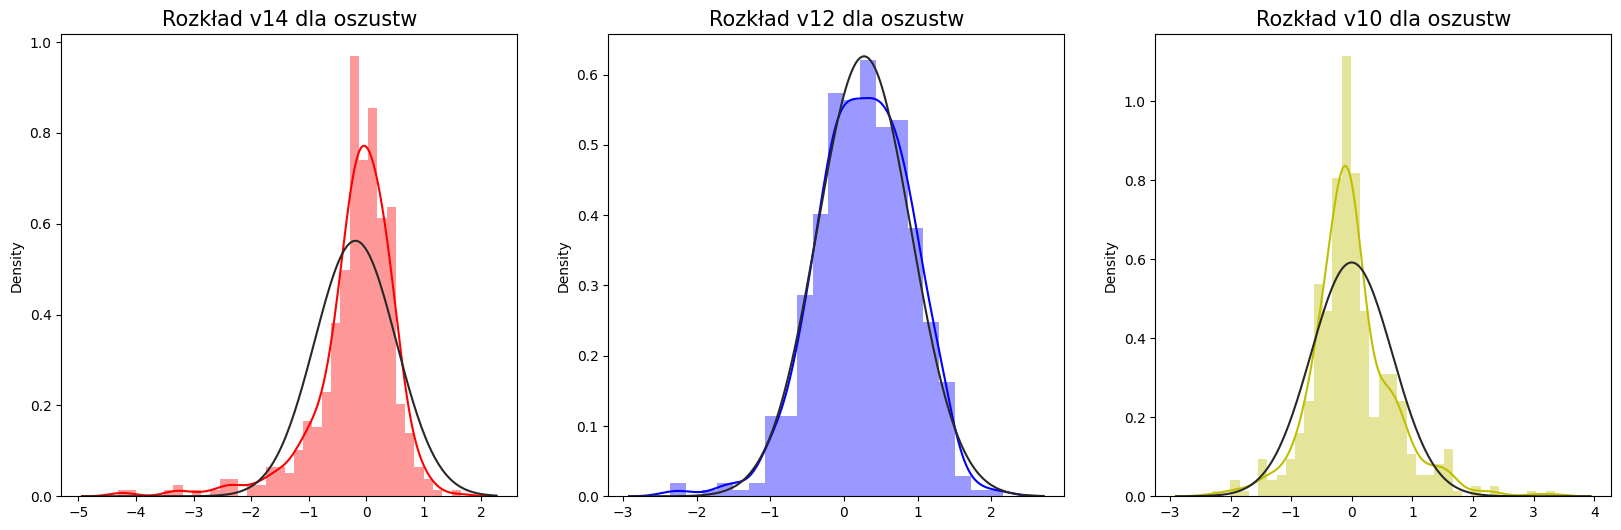

In [34]:
f, (ax1,ax2,ax3, ) = plt.subplots(1,3,figsize=(20,6))

v14_fraud_dist = new_df['V14'].loc[new_df["Class"] == 0].values
sns.distplot(v14_fraud_dist, ax=ax1,fit=norm, color='r')
ax1.set_title('Rozkład v14 dla oszustw', fontsize=15)

v12_fraud_dist = new_df['V12'].loc[new_df["Class"] == 0].values
sns.distplot(v12_fraud_dist, ax=ax2,fit=norm, color='b')
ax2.set_title('Rozkład v12 dla oszustw', fontsize=15)

v10_fraud_dist = new_df['V10'].loc[new_df["Class"] == 0].values
sns.distplot(v10_fraud_dist, ax=ax3,fit=norm, color='y')
ax3.set_title('Rozkład v10 dla oszustw', fontsize=15)

plt.show()

In [35]:
#dimension removal
X,y = new_df.drop("Class",axis=1), new_df["Class"]


In [36]:
#TSNE
X_reduced_tsne = TSNE(n_components=2,random_state=42).fit_transform(X.values)
#PCA
X_reduced_pca = PCA(n_components=2,random_state=42).fit_transform(X.values)
#SVD
X_reduced_svd = TruncatedSVD(n_components=2,random_state=42, algorithm="randomized").fit_transform(X.values)


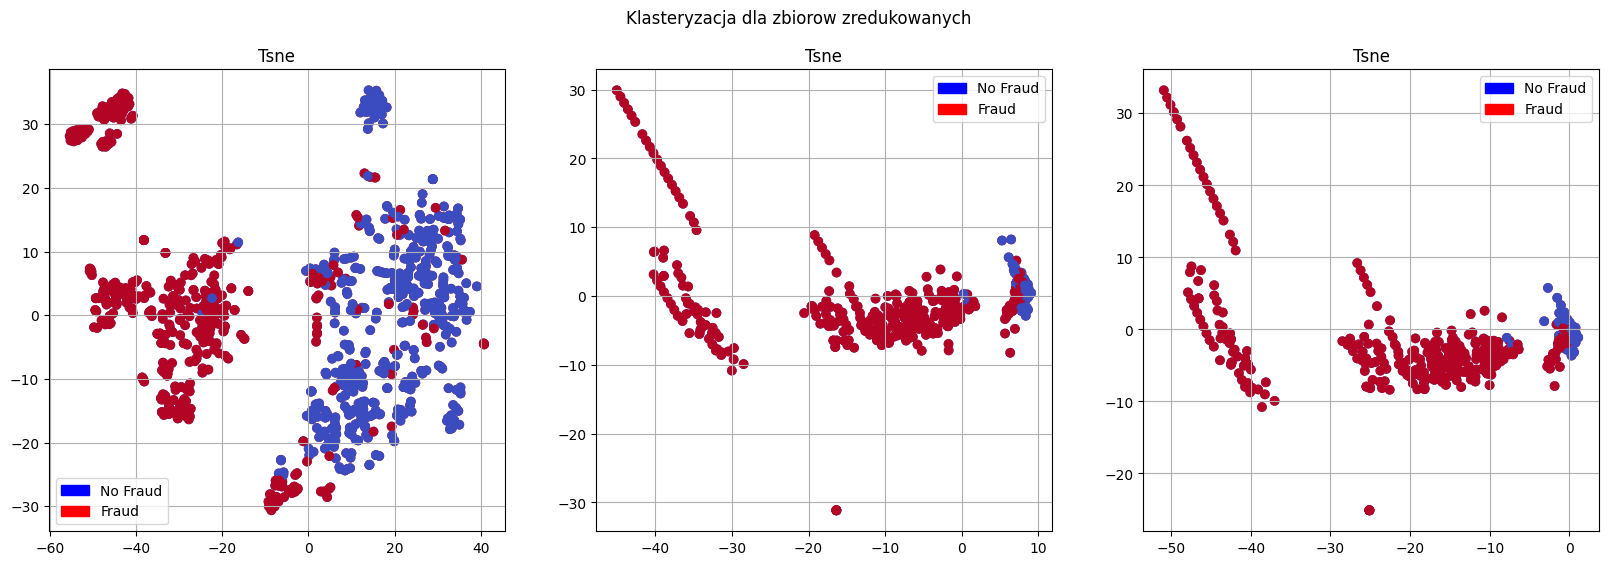

In [37]:
#Clustering
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,6))
f.suptitle("Klasteryzacja dla zbiorow zredukowanych")

blue_patch = mpatches.Patch(color='blue',label='No Fraud')
red_patch = mpatches.Patch(color='red',label='Fraud')

ax1.scatter(X_reduced_tsne[:,0],X_reduced_tsne[:,1],c=(y==0),cmap="coolwarm",label="No Fraud")
ax1.scatter(X_reduced_tsne[:,0],X_reduced_tsne[:,1],c=(y==1),cmap="coolwarm",label="Fraud")
ax1.set_title("Tsne")
ax1.grid(True)
ax1.legend(handles=(blue_patch,red_patch))

ax2.scatter(X_reduced_pca[:,0],X_reduced_pca[:,1],c=(y==0),cmap="coolwarm",label="No Fraud")
ax2.scatter(X_reduced_pca[:,0],X_reduced_pca[:,1],c=(y==1),cmap="coolwarm",label="Fraud")
ax2.set_title("Tsne")
ax2.grid(True)
ax2.legend(handles=(blue_patch,red_patch))

ax3.scatter(X_reduced_svd[:,0],X_reduced_svd[:,1],c=(y==0),cmap="coolwarm",label="No Fraud")
ax3.scatter(X_reduced_svd[:,0],X_reduced_svd[:,1],c=(y==1),cmap="coolwarm",label="Fraud")
ax3.set_title("Tsne")
ax3.grid(True)
ax3.legend(handles=(blue_patch,red_patch))

In [38]:
X, y = new_df.drop("Class", axis =1), new_df['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=42)

classifiers = {
    'LogisticRegression': LogisticRegression(),
    'KNearest': KNeighborsClassifier(),
    'Supoort Vector Classifier': SVC(),
    'DecisionTreeClasidier': DecisionTreeClassifier()
}

In [39]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
  classifier.fit(X_train, Y_train)
  training_score = cross_val_score(classifier, X_train, Y_train, cv=10)
  print("Classidier: ", key, 'Training Score: ', round(training_score.mean(), 2)*100, "% accuracy score")


Classidier:  LogisticRegression Training Score:  98.0 % accuracy score
Classidier:  KNearest Training Score:  94.0 % accuracy score
Classidier:  Supoort Vector Classifier Training Score:  95.0 % accuracy score
Classidier:  DecisionTreeClasidier Training Score:  100.0 % accuracy score


In [40]:
from sklearn.model_selection import GridSearchCV

#Logistic regression

log_reg_parasm = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000], 'solver': ['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga']}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_parasm)
grid_log_reg.fit(X_train, Y_train)
log_reg = grid_log_reg.best_estimator_

log_reg_score = cross_val_score(log_reg, X_train, Y_train, cv=10)

In [41]:
print('LR Cross Validation Score: ', round(log_reg_score.mean(),2)*100, '% accuracy score')

LR Cross Validation Score:  99.0 % accuracy score


In [42]:
knears_params = {'n_neighbors': list(range(2,5,1)), 'algorithm': ['auto','ball_tree','kd_tree','brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, Y_train)
knears_neighbor = grid_knears.best_estimator_

knears_score = cross_val_score(knears_neighbor, X_train, Y_train)
print('Lnears n cross validation score: ', round(knears_score.mean(),2)*100, ' % accuracy score')



Lnears n cross validation score:  95.0  % accuracy score


In [43]:
svc_params = {'C': [0.5,0.7,0.9,1], "kernel" : ['linear','poly','rbf','sigmoid']}

grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, Y_train)
svc_est = grid_svc.best_estimator_

svc_score = cross_val_score(svc_est, X_train, Y_train)
print('Svc cross validation score: ', round(svc_score.mean(),2)*100, '% accuracy score')

Svc cross validation score:  99.0 % accuracy score


In [44]:
tree_params = {"criterion": ['gini','entropy'], 'max_depth': list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)

grid_tree.fit(X_train, Y_train)
tree_est = grid_tree.best_estimator_

tree_score = cross_val_score(tree_est, X_train, Y_train)
print('TREE cross validation score: ', round(tree_score.mean(),2)*100, '% accuracy score')

TREE cross validation score:  100.0 % accuracy score


#Undersampling

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit as sss

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


In [47]:
undersample_x = df.drop('Class', axis=1)
undersample_y = df.Class

sss = sss(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X = undersample_x,y= undersample_y):
    print('Train: ', train_index, 'Test: ', test_index)
    undersample_xtrain, undersample_xtest = undersample_x.iloc[train_index], undersample_x.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_xtrain = undersample_xtrain.values
undersample_xtest = undersample_xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values


undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []


for train_index, test_index in starfield.split(original_Xtrain, original_ytrain):
    x_train, x_test = original_Xtrain[train_index], original_Xtrain[test_index]
    y_train, y_test = original_ytrain[train_index], original_ytrain[test_index]

    pipeline = imbalanced_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    model = pipeline.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    undersample_accuracy.append(model.score(x_test, y_test))
    undersample_precision.append(precision_score(y_test, y_pred))
    undersample_recall.append(recall_score(y_test, y_pred))
    undersample_f1.append(f1_score(y_test, y_pred))
    undersample_auc.append(roc_auc_score(y_test, y_pred))


print("Średnia Accuracy:", np.mean(undersample_accuracy))
print("Średnia Precision:", np.mean(undersample_precision))
print("Średnia Recall:", np.mean(undersample_recall))
print("Średnia F1:", np.mean(undersample_f1))
print("Średnia AUC:", np.mean(undersample_auc))

Train:  [ 91642 115978  71203 ... 202220 152368  93970] Test:  [111114  18951 207939 ...  31635  11008 189696]
Średnia Accuracy: 0.44580055988566736
Średnia Precision: 0.0030918084774571772
Średnia Recall: 0.9532467532467532
Średnia F1: 0.006163125123917227
Średnia AUC: 0.6990760275875998


In [ ]:
#plot ROC CURVE
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, original_Xtrain, original_ytrain, cv=5, method='decision_function')
svc_pred = cross_val_predict(svc_est, original_Xtrain, original_ytrain, cv=5, method='decision_function')
knears_pred = cross_val_predict(knears_neighbor, original_Xtrain, original_ytrain, cv=5)
tree_pred = cross_val_predict(tree_est, original_Xtrain, original_ytrain, cv=5)


from sklearn.metrics import roc_auc_score

log_fpr, log_tpr, log_thresold = roc_curve(original_ytrain, log_reg_pred)
knear_fpr, knear_tpr, knear_thresold = roc_curve(original_ytrain, knears_pred)
svc_fpr, svc_tpr, svc_thresold = roc_curve(original_ytrain, svc_pred)
tree_fpr, tree_tpr, tree_thresold = roc_curve(original_ytrain, tree_pred)

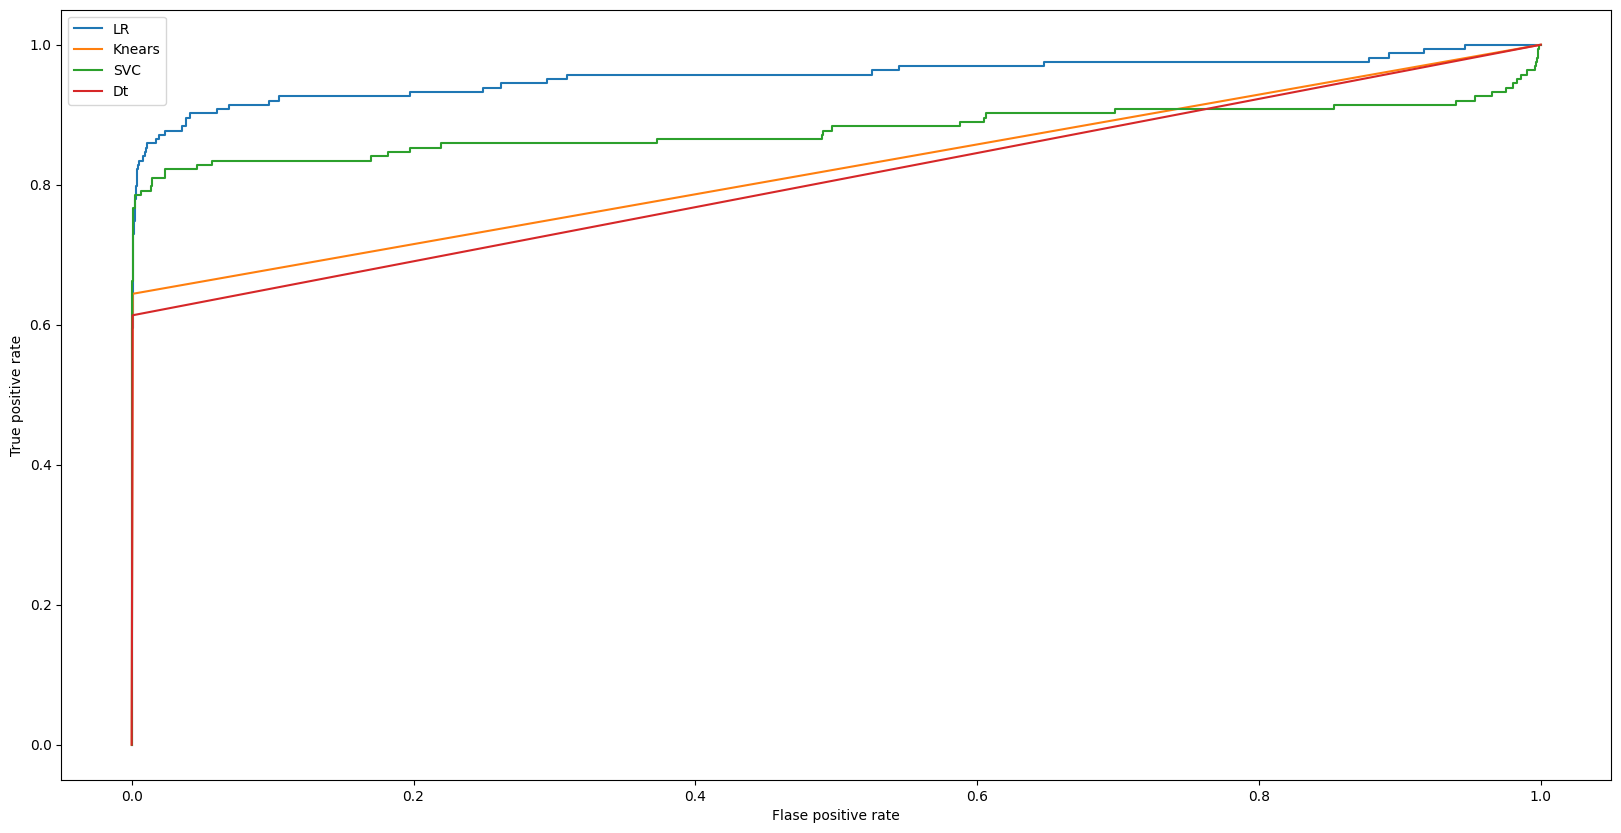

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(log_fpr, log_tpr, label="LR")
plt.plot(knear_fpr,knear_tpr, label="Knears")
plt.plot(svc_fpr, svc_tpr, label="SVC")
plt.plot(tree_fpr, tree_tpr, label="Dt")

plt.legend()
plt.xlabel("Flase positive rate")
plt.ylabel("True positive rate")

plt.show()